#HW5

Following the paper "Examining the feasibility of using open data to benchmark building energy usage in cities: A data science and policy perspective" [Roth et al 2019](https://www.researchgate.net/publication/337074109_Examining_the_feasibility_of_using_open_data_to_benchmark_building_energy_usage_in_cities_A_data_science_and_policy_perspective), choose 2 cities in the dataset available through the paper's github repository https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking

This paper is an excellent example of reproducible research.

I also created an example of using random forest classifier and regressors here https://github.com/fedhere/PUS2022_FBianco/blob/master/classdemo/COVID19LOS_featureExtractionRFexample.ipynb and there are links at the bottom of this notebook to useful functions and examples on the internet of applications of methods you will need to use.

1. Read the introduction to the paper and describe here (briefly) the goals of their analysis (and the analysis that you are about to reproduce). Max 200 words.
2. Choose 2 cities (any 2 cities except Seattle cause I am running some of the Seattle analysis below for guidance)
3. For each of the 2 cities reproduce their analysis by

  3.1 gathering the original data from their repository (see below for Seattle example)

  3.2 clean the data according to their data preparation scheme, including one-hot-encoding categorical variables, except to impute missing data using KNearestNeighors instead of Gibbs sampling (see below)

  3.3 run a Random Forest (RF) Regressor to predict the total energy consumption.

  3.4 evaluate the RF model performance by printing the R2 score (the default score in SKLearn RF) for training and test set (discuss)

  3.5 plot the features sorted by their importance and identify the most important features. are they consistent between the 2 cities? are they consistent with the paper's result?
4 compare the result for the 2 cities (discuss)

5. Extra credit:

  5.1 modify the target variable to a binary variable choosing the median of the variable values as the the energy threshold and predict whether the value is higher or lower than the threshold
  5.2 Run a Random Forest Classifier to predict if an observation is in the upper 50% percentile or lower 50% percentile (above or below the median threshold)
  5.3 Measure the performance of the model on training and test data
  5.4 Measure the feature importance and assess if the important feature have changed (discuss)

# choose a city and read in the data

In [59]:
import pandas as pd
import numpy as np
import missingno as msno

In [60]:
boston = pd.read_csv("https://raw.githubusercontent.com/Urban-Informatics-Lab/Open-Data-Benchmarking/refs/heads/master/Boston/boston_final.csv")

# inspect the dataframe

In [61]:
print("there are (rows, columns) = ", (boston.shape), "in the boston dataframe")

there are (rows, columns) =  (1599, 16) in the boston dataframe


In [62]:
boston.columns

Index(['Unnamed: 0', 'reported', 'property_type', 'gross_area_SF',
       'year_built', 'h2o_intensity_GALSF', 'zip', 'property_uses',
       'site_eui_KBTUSF', 'energy_star_score', 'ghg_emissions_MTCO2e',
       'ghg_intens_KGCO2SF', 'total_site_energy_KBTU',
       'log_total_site_energy_KBTU', 'electricity_percentage',
       'gas_percentage'],
      dtype='object')

In [63]:
boston.describe()

,Unnamed: 0,gross_area_SF,year_built,h2o_intensity_GALSF,site_eui_KBTUSF,energy_star_score,ghg_emissions_MTCO2e,ghg_intens_KGCO2SF,total_site_energy_KBTU,log_total_site_energy_KBTU,electricity_percentage,gas_percentage
count,1599.000000,1.599000e+03,1599.000000,1.599000e+03,1599.000000,1076.000000,1599.000000,1598.000000,1.599000e+03,1599.000000,1577.000000,1306.000000
mean,901.190119,1.494918e+05,1954.343340,1.673398e+06,82.131207,68.187732,1954.343340,5.547810,1.325400e+07,15.386588,47.041725,56.545865
std,516.225894,2.713492e+05,70.996812,3.822188e+07,56.144612,29.637595,70.996812,3.865617,3.927494e+07,1.434270,29.181977,27.063293
min,3.000000,1.000000e+00,1000.000000,0.000000e+00,1.300000,1.000000,1000.000000,0.000000,1.426290e+04,9.565417,0.000000,0.000000
25%,459.500000,3.880350e+04,1920.000000,1.090000e+01,49.300000,49.750000,1920.000000,3.300000,2.139090e+06,14.575890,22.800000,38.900000
50%,894.000000,7.000000e+04,1969.000000,2.330000e+01,69.000000,78.000000,1969.000000,4.700000,4.840347e+06,15.392497,41.000000,61.350000
75%,1345.500000,1.490590e+05,2000.000000,4.385000e+01,99.200000,93.000000,2000.000000,6.700000,1.191536e+07,16.293339,66.600000,78.500000
max,1799.000000,4.699442e+06,2016.000000,8.829243e+08,323.600000,100.000000,2016.000000,24.300000,9.747548e+08,20.697697,100.000000,100.000000


<Axes: >

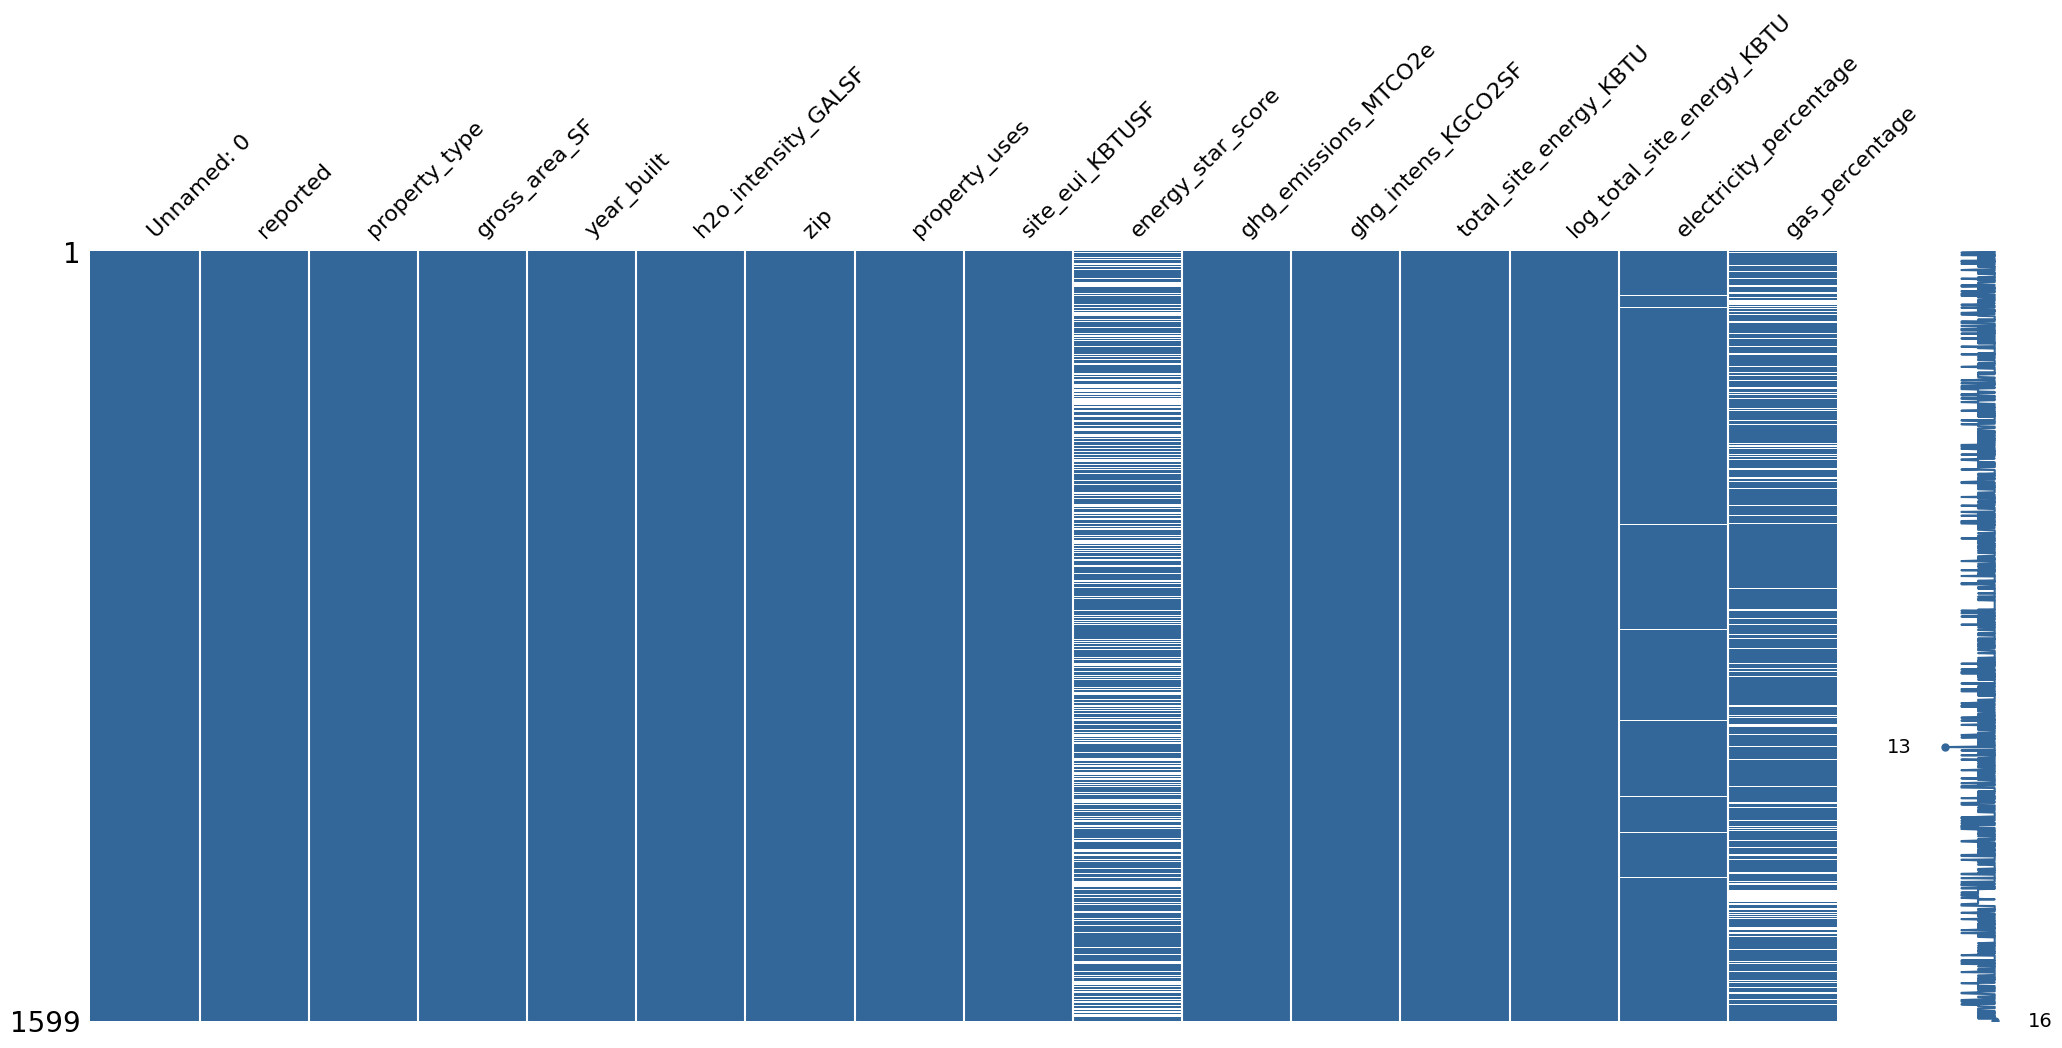

In [64]:
msno.matrix(boston, color=(0.2, 0.4, 0.6))

# TASK 1 Clean the data
follow closely the second paragraph of Section 4 DATA. Name each step you do accordingly to the description in the paragraf
https://www.researchgate.net/publication/337074109_Examining_the_feasibility_of_using_open_data_to_benchmark_building_energy_usage_in_cities_A_data_science_and_policy_perspective

you can also help yourself inspecting the final datasets posted on the github repo but name each action according to the paper narrative: for example, if you drop "Building ID" indicate that this is done as part of
_We then cleaned the datasets by removing irrelevant building-identifying features (such as
address)_, or if dropping a variable with too many missing values _removing features that had missing values for greater than 40% of the buildings in the dataset._

In [65]:
# summarize the number of rows with missing values for each column
for c in boston.columns:

  # count number of rows with missing values
  n_miss = boston[c].isnull().sum()
  perc = n_miss / boston.shape[0] * 100
  print('%s (%s):  Missing: %d (%.1f%%)' % (c, boston[c].dtype,
                                                  n_miss, perc))


Unnamed: 0 (int64):  Missing: 0 (0.0%)
reported (object):  Missing: 0 (0.0%)
property_type (object):  Missing: 0 (0.0%)
gross_area_SF (float64):  Missing: 0 (0.0%)
year_built (int64):  Missing: 0 (0.0%)
h2o_intensity_GALSF (float64):  Missing: 0 (0.0%)
zip (object):  Missing: 0 (0.0%)
property_uses (object):  Missing: 0 (0.0%)
site_eui_KBTUSF (float64):  Missing: 0 (0.0%)
energy_star_score (float64):  Missing: 523 (32.7%)
ghg_emissions_MTCO2e (int64):  Missing: 0 (0.0%)
ghg_intens_KGCO2SF (float64):  Missing: 1 (0.1%)
total_site_energy_KBTU (float64):  Missing: 0 (0.0%)
log_total_site_energy_KBTU (float64):  Missing: 0 (0.0%)
electricity_percentage (float64):  Missing: 22 (1.4%)
gas_percentage (float64):  Missing: 293 (18.3%)


In [66]:
boston.head()

,Unnamed: 0,reported,property_type,gross_area_SF,year_built,h2o_intensity_GALSF,zip,property_uses,site_eui_KBTUSF,energy_star_score,ghg_emissions_MTCO2e,ghg_intens_KGCO2SF,total_site_energy_KBTU,log_total_site_energy_KBTU,electricity_percentage,gas_percentage
0,3,Yes,Multifamily Housing,117241.0,1905,37.1,01234,Multifamily Housing,42.6,99.0,1905,4.0,4998855.7,15.424720,40.4,59.6
1,4,Yes,Multifamily Housing,178000.0,1900,29.8,02021,Multifamily Housing,56.8,92.0,1900,3.5,10109996.3,16.129035,25.8,74.2
2,5,Yes,Office,58921.0,1924,10.9,02026,Office,26.3,100.0,1924,2.3,1552224.5,14.255200,100.0,NaN
3,6,Yes,Parking,160180.0,1980,0.1,02038,Parking,5.1,NaN,1980,0.4,679479.3,13.429082,100.0,NaN
4,7,Yes,Office,1136283.0,1973,10.2,02108,"Data Center, Office, Parking",98.2,82.0,1973,7.3,111572120.2,18.530182,43.6,1.0


In [67]:
#dropping irrelevant data
boston.drop(["reported"], axis=1, inplace=True) #Category code
boston.drop(["Unnamed: 0"], axis=1,inplace=True)

print("there are (rows, columns) = ", (boston.shape), "in the dataframe")


there are (rows, columns) =  (1599, 14) in the dataframe


In [68]:
for c in boston.columns:

  # count number of rows with missing values
  n_miss = boston[c].isnull().sum()
  perc = n_miss / boston.shape[0] * 100
  print('%s (%s):  Missing: %d (%.1f%%)' % (c, boston[c].dtype,
                                                  n_miss, perc))

property_type (object):  Missing: 0 (0.0%)
gross_area_SF (float64):  Missing: 0 (0.0%)
year_built (int64):  Missing: 0 (0.0%)
h2o_intensity_GALSF (float64):  Missing: 0 (0.0%)
zip (object):  Missing: 0 (0.0%)
property_uses (object):  Missing: 0 (0.0%)
site_eui_KBTUSF (float64):  Missing: 0 (0.0%)
energy_star_score (float64):  Missing: 523 (32.7%)
ghg_emissions_MTCO2e (int64):  Missing: 0 (0.0%)
ghg_intens_KGCO2SF (float64):  Missing: 1 (0.1%)
total_site_energy_KBTU (float64):  Missing: 0 (0.0%)
log_total_site_energy_KBTU (float64):  Missing: 0 (0.0%)
electricity_percentage (float64):  Missing: 22 (1.4%)
gas_percentage (float64):  Missing: 293 (18.3%)


# TASK 2: transform input feature as needed
for example replace features with log features. Guide yourself with the text, the final dataset names, and also the code here https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/blob/master/Lasso_RandomForest.Rmd

In [69]:
boston.describe() #what should you look at in the result below?

,gross_area_SF,year_built,h2o_intensity_GALSF,site_eui_KBTUSF,energy_star_score,ghg_emissions_MTCO2e,ghg_intens_KGCO2SF,total_site_energy_KBTU,log_total_site_energy_KBTU,electricity_percentage,gas_percentage
count,1.599000e+03,1599.000000,1.599000e+03,1599.000000,1076.000000,1599.000000,1598.000000,1.599000e+03,1599.000000,1577.000000,1306.000000
mean,1.494918e+05,1954.343340,1.673398e+06,82.131207,68.187732,1954.343340,5.547810,1.325400e+07,15.386588,47.041725,56.545865
std,2.713492e+05,70.996812,3.822188e+07,56.144612,29.637595,70.996812,3.865617,3.927494e+07,1.434270,29.181977,27.063293
min,1.000000e+00,1000.000000,0.000000e+00,1.300000,1.000000,1000.000000,0.000000,1.426290e+04,9.565417,0.000000,0.000000
25%,3.880350e+04,1920.000000,1.090000e+01,49.300000,49.750000,1920.000000,3.300000,2.139090e+06,14.575890,22.800000,38.900000
50%,7.000000e+04,1969.000000,2.330000e+01,69.000000,78.000000,1969.000000,4.700000,4.840347e+06,15.392497,41.000000,61.350000
75%,1.490590e+05,2000.000000,4.385000e+01,99.200000,93.000000,2000.000000,6.700000,1.191536e+07,16.293339,66.600000,78.500000
max,4.699442e+06,2016.000000,8.829243e+08,323.600000,100.000000,2016.000000,24.300000,9.747548e+08,20.697697,100.000000,100.000000


In [70]:
boston.info() #why is this helpful to print?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   property_type               1599 non-null   object 
 1   gross_area_SF               1599 non-null   float64
 2   year_built                  1599 non-null   int64  
 3   h2o_intensity_GALSF         1599 non-null   float64
 4   zip                         1599 non-null   object 
 5   property_uses               1599 non-null   object 
 6   site_eui_KBTUSF             1599 non-null   float64
 7   energy_star_score           1076 non-null   float64
 8   ghg_emissions_MTCO2e        1599 non-null   int64  
 9   ghg_intens_KGCO2SF          1598 non-null   float64
 10  total_site_energy_KBTU      1599 non-null   float64
 11  log_total_site_energy_KBTU  1599 non-null   float64
 12  electricity_percentage      1577 non-null   float64
 13  gas_percentage              1306 

## Throw away data where the **target** variable is missing

I will remove each row where I do not have the target variable. To do that I use `df.dropna()` and the subset argument of `df.dropna()` set to the name of the variable. The `how` should be set to "any" cause you want to drop the row where any values in the subset is NaN (this is a subset of one column, so it is obvious, but imagine if you were passing more than one column to the call `dropna()`

In [71]:
boston["total_site_energy_KBTU"].isna().sum()

0

<Axes: >

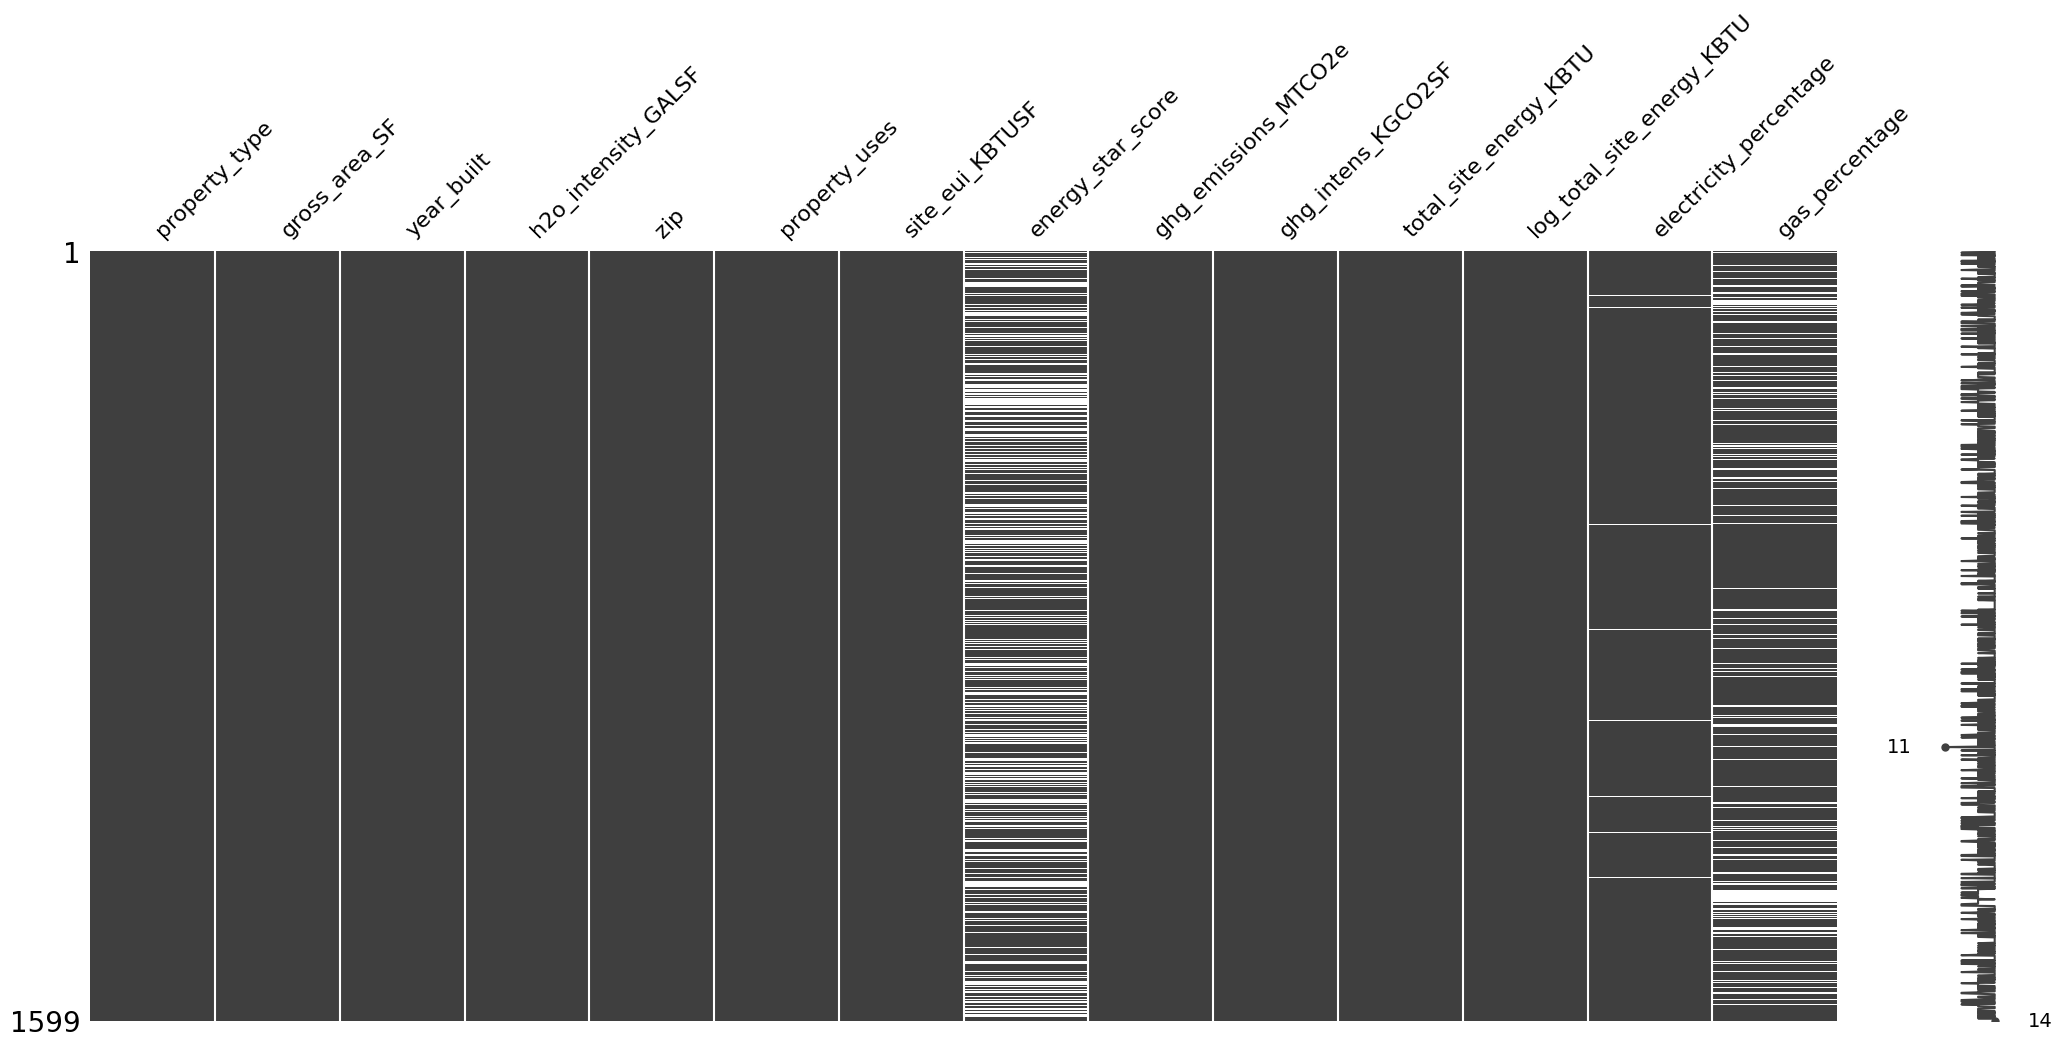

In [72]:
msno.matrix(boston)

In [73]:
# isolate the target variable first (endogenous)
y = boston['total_site_energy_KBTU'].values

In [74]:
# and the input variables (exogenous)
#X = boston.drop('total_site_energy_KBTU', axis=1)
X = boston

In [75]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   property_type               1599 non-null   object 
 1   gross_area_SF               1599 non-null   float64
 2   year_built                  1599 non-null   int64  
 3   h2o_intensity_GALSF         1599 non-null   float64
 4   zip                         1599 non-null   object 
 5   property_uses               1599 non-null   object 
 6   site_eui_KBTUSF             1599 non-null   float64
 7   energy_star_score           1076 non-null   float64
 8   ghg_emissions_MTCO2e        1599 non-null   int64  
 9   ghg_intens_KGCO2SF          1598 non-null   float64
 10  total_site_energy_KBTU      1599 non-null   float64
 11  log_total_site_energy_KBTU  1599 non-null   float64
 12  electricity_percentage      1577 non-null   float64
 13  gas_percentage              1306 

### separate categorical and numerical values
you will proceed to missing data imputation differently in the 2 cases

In [76]:
# I am giving you the solution but please take note of how one does this!
X_numeric_data = X.select_dtypes(include=[np.number])
X_categorical_data = X.select_dtypes(exclude=[np.number])

In [77]:
X_numeric_data.shape

(1599, 11)

In [78]:
X_numeric_data.head() ## is there anything suspicious? anything thas is in fact **not** a numerical variable? that will depend on how you did in TASK 1

,gross_area_SF,year_built,h2o_intensity_GALSF,site_eui_KBTUSF,energy_star_score,ghg_emissions_MTCO2e,ghg_intens_KGCO2SF,total_site_energy_KBTU,log_total_site_energy_KBTU,electricity_percentage,gas_percentage
0,117241.0,1905,37.1,42.6,99.0,1905,4.0,4998855.7,15.424720,40.4,59.6
1,178000.0,1900,29.8,56.8,92.0,1900,3.5,10109996.3,16.129035,25.8,74.2
2,58921.0,1924,10.9,26.3,100.0,1924,2.3,1552224.5,14.255200,100.0,NaN
3,160180.0,1980,0.1,5.1,NaN,1980,0.4,679479.3,13.429082,100.0,NaN
4,1136283.0,1973,10.2,98.2,82.0,1973,7.3,111572120.2,18.530182,43.6,1.0


In [79]:
X_categorical_data.shape

(1599, 3)

In [80]:
X_categorical_data.columns

Index(['property_type', 'zip', 'property_uses'], dtype='object')

## TASK 2.1: make a scatter plot to assess covariance of numerical variables

### IMPORTANT!!

there are going to be some **very** collinear variable - zoom in and chek them out - what are they? You will need to remove variables that are _identical_, because you obviously do not want to imput the data twice in the model - it will not improve the model and it will impact the feature importance analysis.

What else looks like it should be removed?

**Reason about it and explain your choices in the caption of the figure**



In [81]:
'''# THIS TAKES A LOOOONG TIME! ~10 MINUTES ON COLAB FOR ME
import seaborn as sns
sns.pairplot(X_numeric_data)
# DELETE OUTPUT!'''

'# THIS TAKES A LOOOONG TIME! ~10 MINUTES ON COLAB FOR ME\nimport seaborn as sns\nsns.pairplot(X_numeric_data)\n# DELETE OUTPUT!'

In [82]:
X_numeric_data.describe()

,gross_area_SF,year_built,h2o_intensity_GALSF,site_eui_KBTUSF,energy_star_score,ghg_emissions_MTCO2e,ghg_intens_KGCO2SF,total_site_energy_KBTU,log_total_site_energy_KBTU,electricity_percentage,gas_percentage
count,1.599000e+03,1599.000000,1.599000e+03,1599.000000,1076.000000,1599.000000,1598.000000,1.599000e+03,1599.000000,1577.000000,1306.000000
mean,1.494918e+05,1954.343340,1.673398e+06,82.131207,68.187732,1954.343340,5.547810,1.325400e+07,15.386588,47.041725,56.545865
std,2.713492e+05,70.996812,3.822188e+07,56.144612,29.637595,70.996812,3.865617,3.927494e+07,1.434270,29.181977,27.063293
min,1.000000e+00,1000.000000,0.000000e+00,1.300000,1.000000,1000.000000,0.000000,1.426290e+04,9.565417,0.000000,0.000000
25%,3.880350e+04,1920.000000,1.090000e+01,49.300000,49.750000,1920.000000,3.300000,2.139090e+06,14.575890,22.800000,38.900000
50%,7.000000e+04,1969.000000,2.330000e+01,69.000000,78.000000,1969.000000,4.700000,4.840347e+06,15.392497,41.000000,61.350000
75%,1.490590e+05,2000.000000,4.385000e+01,99.200000,93.000000,2000.000000,6.700000,1.191536e+07,16.293339,66.600000,78.500000
max,4.699442e+06,2016.000000,8.829243e+08,323.600000,100.000000,2016.000000,24.300000,9.747548e+08,20.697697,100.000000,100.000000


In [83]:
# this does not have to be identical to my output as you may have dropped different variables
print("there are (rows, columns) = ", X_numeric_data.shape, "in the numerical variables")

there are (rows, columns) =  (1599, 11) in the numerical variables


As they do in the original research https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/blob/master/Lasso_RandomForest.Rmd we should transform some variables into their log values

their original code (which is in R not in python!) is
```
x_seattle$log_total_area=log(x_seattle$gross_floor_area_total_SF)
x_seattle$log_parking_area=log(x_seattle$gross_floor_area_parking_SF)
x_seattle$log_bldg_area=log(x_seattle$gross_floor_area_building_SF)
x_seattle$log_area_1=log(x_seattle$gross_floor_area_property_type_first_SF)

```
the names are a bit different


In [84]:
X_numeric_data.columns

Index(['gross_area_SF', 'year_built', 'h2o_intensity_GALSF', 'site_eui_KBTUSF',
       'energy_star_score', 'ghg_emissions_MTCO2e', 'ghg_intens_KGCO2SF',
       'total_site_energy_KBTU', 'log_total_site_energy_KBTU',
       'electricity_percentage', 'gas_percentage'],
      dtype='object')

In [85]:
# note: recheck missing values
# this is important: after I apply the log function to some variables cause log(0) = -infinity
print("there are {} missing or infinity values in the numerical data".format(X_numeric_data.isnull().sum().sum()))

there are 839 missing or infinity values in the numerical data


In [86]:
# translated to python
X_numeric_data["total_site_energy_KBTU"] = np.log10(X_numeric_data["total_site_energy_KBTU"])
X_numeric_data.rename(columns={'total_site_energy_KBTU': 'log10_total_site_energy_KBTU'}, inplace=True)
#X_numeric_data.rename(columns={'log_total_site_energy_KBTU': 'ln_total_site_energy_KBTU'}, inplace=True)

X_numeric_data["ghg_emissions_MTCO2e"] = np.log10(X_numeric_data["ghg_emissions_MTCO2e"])
X_numeric_data.rename(columns={'ghg_emissions_MTCO2e': 'log10_ghg_emissions_MTCO2e'}, inplace=True)

X_numeric_data["gross_area_SF"] = np.log10(X_numeric_data["gross_area_SF"])
X_numeric_data.rename(columns={'gross_area_SF': 'log10_gross_area_SF'}, inplace=True)

X_numeric_data["h2o_intensity_GALSF"] = np.log10(X_numeric_data["h2o_intensity_GALSF"])
X_numeric_data.rename(columns={'h2o_intensity_GALSF': 'log10_h2o_intensity_GALSF'}, inplace=True)

X_numeric_data["site_eui_KBTUSF"] = np.log10(X_numeric_data["site_eui_KBTUSF"])
X_numeric_data.rename(columns={'site_eui_KBTUSF': 'log10_site_eui_KBTUSF'}, inplace=True)

#replace ... with your code

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [87]:
X_numeric_data.head()

,log10_gross_area_SF,year_built,log10_h2o_intensity_GALSF,log10_site_eui_KBTUSF,energy_star_score,log10_ghg_emissions_MTCO2e,ghg_intens_KGCO2SF,log10_total_site_energy_KBTU,log_total_site_energy_KBTU,electricity_percentage,gas_percentage
0,5.069080,1905,1.569374,1.629410,99.0,3.279895,4.0,6.698871,15.424720,40.4,59.6
1,5.250420,1900,1.474216,1.754348,92.0,3.278754,3.5,7.004751,16.129035,25.8,74.2
2,4.770270,1924,1.037426,1.419956,100.0,3.284205,2.3,6.190955,14.255200,100.0,NaN
3,5.204608,1980,-1.000000,0.707570,NaN,3.296665,0.4,5.832176,13.429082,100.0,NaN
4,6.055487,1973,1.008600,1.992111,82.0,3.295127,7.3,8.047556,18.530182,43.6,1.0


In [88]:
print("number of infinite values:", (np.isinf(X_numeric_data)).sum().sum())

number of infinite values: 13


check what happened to missing values: they may have grown! because  log(0) = -infinity - fix infinities replacing them with NaN

(in in https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/blob/master/Lasso_RandomForest.Rmd they had replaced them with 0 but I object to that)

In [89]:
# this has to return 0 now
X_numeric_data.replace(-np.inf, np.nan, inplace=True)
print("number of infinite values:", (np.isinf(X_numeric_data)).sum().sum())

number of infinite values: 0


In [90]:
print("the numerical data contains (rows, columns) = ", X_numeric_data.shape)
print("there are {} missing values in the numerical data".format(X_numeric_data.isnull().sum().sum()))

the numerical data contains (rows, columns) =  (1599, 11)
there are 852 missing values in the numerical data



you can use `KNNImputer` on the numerical variables, but KNNImputer would fail on categorical variables so you are left with NaNs on categorical variables, which you then need to drop before you run the Random Forest


You can impute separately the numerical and categorical variables, the numerical ones with KNNImputer and the categorical ones with SimpleImputer

## TASK 2.2 use Nearest Neighbor Imputer to impute missing values in numerical features

here we are deviating from the paper. NN imputation is simpler and more common, I think it may be more useful to you in general

In [91]:
from sklearn.impute import KNNImputer

imputer = KNNImputer() #replace ... with your code
Xn = imputer.fit_transform(X_numeric_data)
Xn

array([[5.06907951e+00, 1.90500000e+03, 1.56937391e+00, ...,
        1.54247196e+01, 4.04000000e+01, 5.96000000e+01],
       [5.25042000e+00, 1.90000000e+03, 1.47421626e+00, ...,
        1.61290352e+01, 2.58000000e+01, 7.42000000e+01],
       [4.77027011e+00, 1.92400000e+03, 1.03742650e+00, ...,
        1.42551996e+01, 1.00000000e+02, 6.03000000e+01],
       ...,
       [4.74763705e+00, 2.00200000e+03, 1.49276039e+00, ...,
        1.65483370e+01, 7.16000000e+01, 2.84000000e+01],
       [4.87506126e+00, 1.90000000e+03, 1.44404480e+00, ...,
        1.55843871e+01, 1.98000000e+01, 8.02000000e+01],
       [4.60138631e+00, 1.96000000e+03, 1.75891189e+00, ...,
        1.58933426e+01, 4.13000000e+01, 5.87000000e+01]])

In [92]:
Xn_col = X_numeric_data.columns
Xn_col
Xnl = np.vstack((Xn_col, Xn))
Xnl

array([['log10_gross_area_SF', 'year_built', 'log10_h2o_intensity_GALSF',
        ..., 'log_total_site_energy_KBTU', 'electricity_percentage',
        'gas_percentage'],
       [5.069079514070643, 1905.0, 1.5693739096150459, ...,
        15.4247195842059, 40.4, 59.6],
       [5.250420002308894, 1900.0, 1.4742162640762553, ...,
        16.1290352250223, 25.8, 74.2],
       ...,
       [4.747637054294019, 2002.0, 1.4927603890268375, ...,
        16.5483370104355, 71.6, 28.4],
       [4.8750612633917, 1900.0, 1.4440447959180762, ...,
        15.584387115688, 19.8, 80.2],
       [4.601386312645053, 1960.0, 1.7589118923979736, ...,
        15.8933426051024, 41.3, 58.7]], dtype=object)

<Axes: >

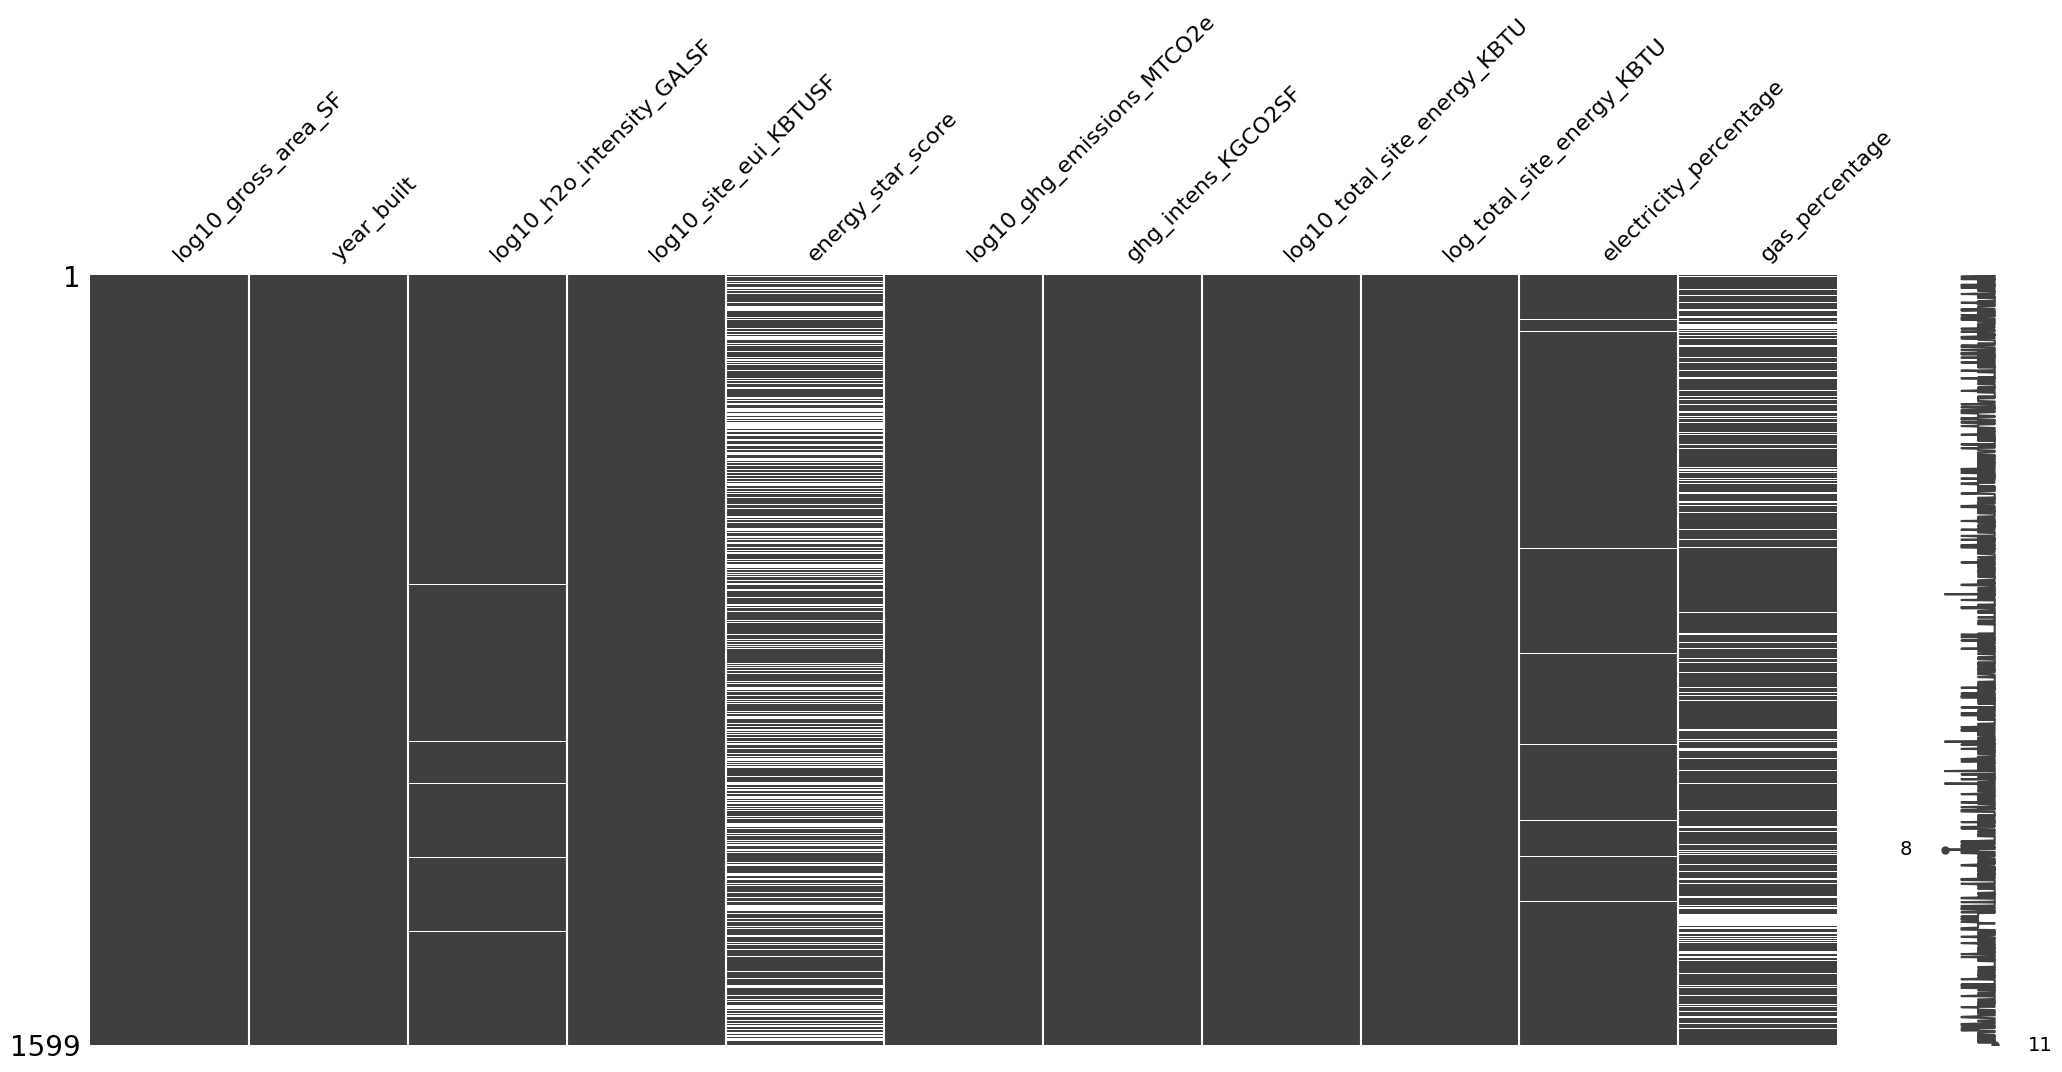

In [93]:
msno.matrix(X_numeric_data)

## TASK 2.3 Impute missing categorial variables
you will have to remove Nan values and replace them.

You can use `sklearn.impute.SimpleImputer using strategy="most_frequent"` on all variables, but you will have a naif solution for numerical imputations

I prefer to replace them with "None" or a similar string, for which you can use the fillna method: ```df.fillna("None")``` and leave it at that or with a little more effort you can input values based on nearest neighbors or some other inputation scheme. any choice goes so long as it is well described and justified with words.

<Axes: >

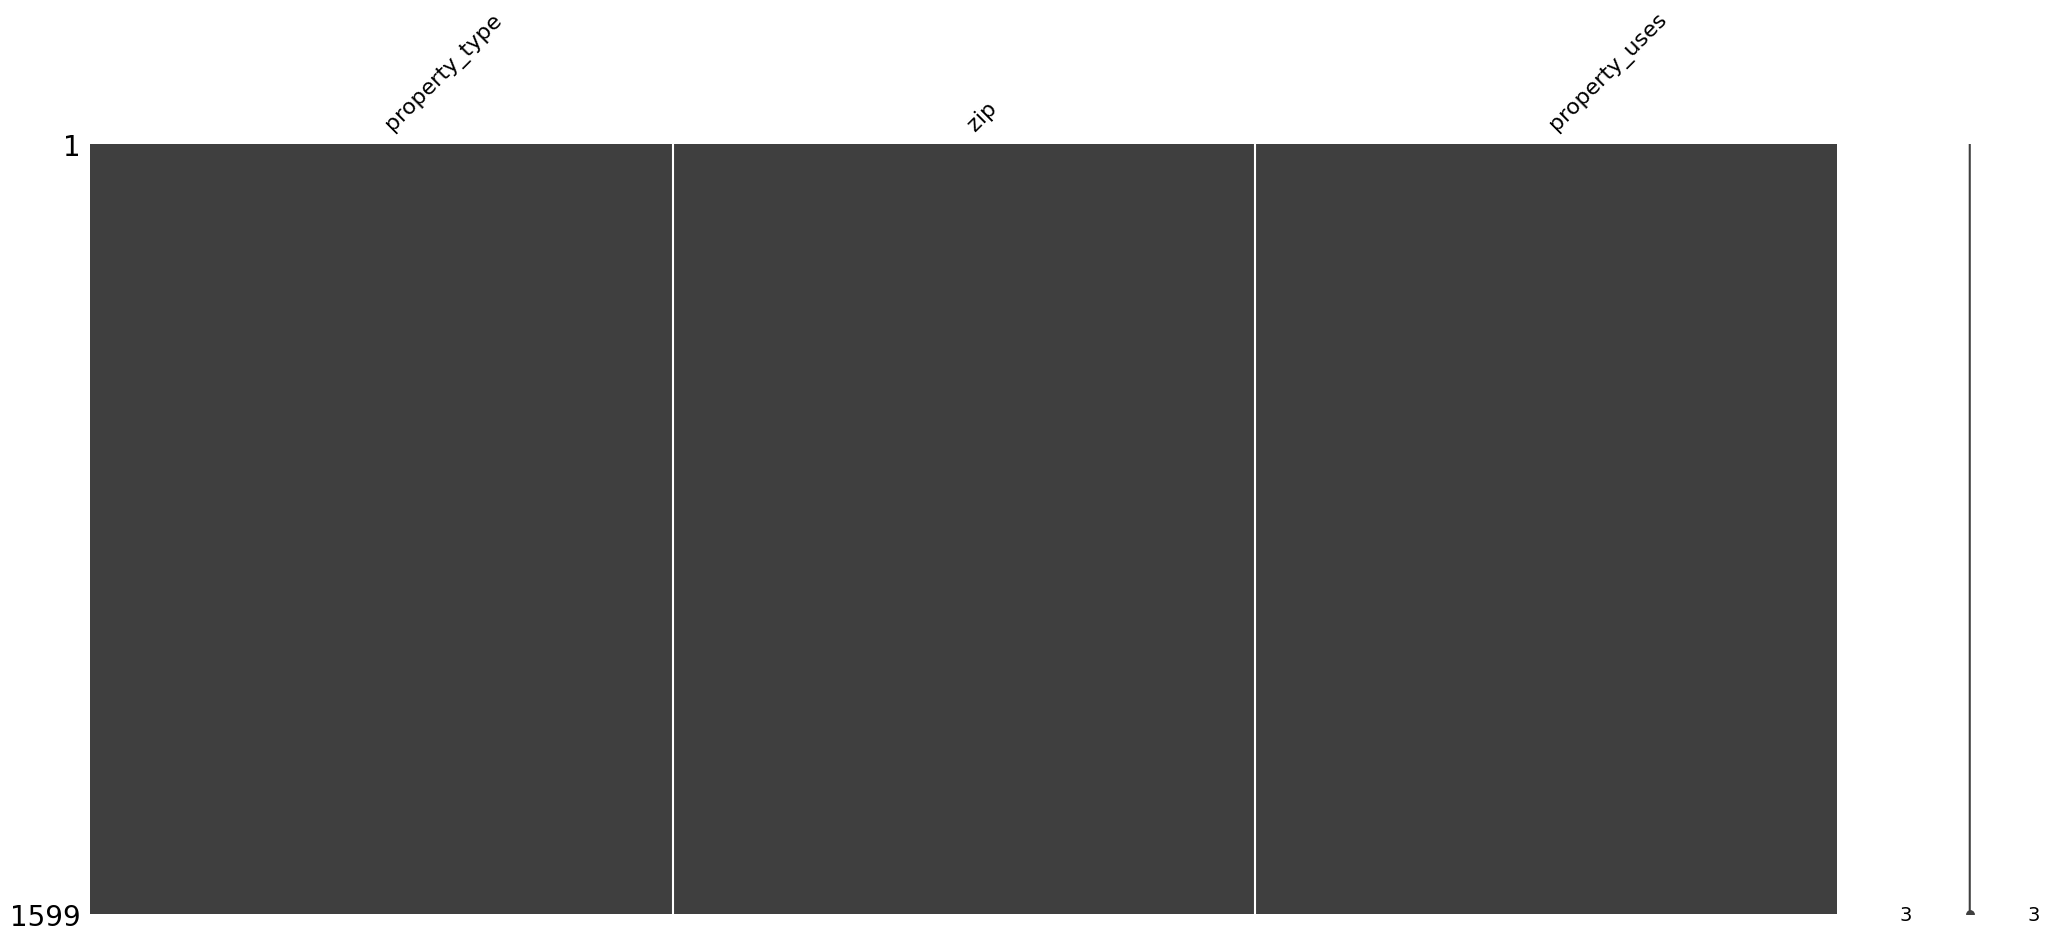

In [94]:
X_categorical_data = X_categorical_data.fillna("None")
msno.matrix(X_categorical_data)

# TASK 3 One Hot Encode the Categorical Variables

Hint: Once you have done the fit and the transformation, which gives you the transformed data according to the new encoding, what you get is normally a sparse matrix. In principle there is an argument `sparse` to `OneHotEncoder` which should prevent this and give you a dense matrix, which is much easier to handle (consider asking me or looking up what is a sparse matrix!). That attribute did not work for me so once I applied the new encoding I converted the result to a dense matrix as
`Xc = Xc.todense()`

Finally, you will need to use a specific method to get the new names of the variables. Its a method of your model (which I called ohe below) and you can find it in this page here https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [95]:
X_categorical_data.describe()

,property_type,zip,property_uses
count,1599,1599,1599
unique,62,53,221
top,Multifamily Housing,02215,Multifamily Housing
freq,539,131,413


In [96]:
from sklearn.preprocessing import OneHotEncoder
# DELETE
#your code here

ohe = OneHotEncoder() #replace ... with your code

Xc = ohe.fit_transform(X_categorical_data)

Xc.shape

(1599, 336)

In [97]:
# there is a speific method of ohe that allows you to get the names of the features after the encoding is done
feature_name_cat = ohe.get_feature_names_out() #replace ... with your code
feature_name_cat

array(['property_type_Adult Education',
       'property_type_Ambulatory Surgical Center',
       'property_type_Aquarium', 'property_type_Automobile Dealership',
       'property_type_Barracks', 'property_type_College/University',
       'property_type_Courthouse', 'property_type_Distribution Center',
       'property_type_Enclosed Mall',
       'property_type_Energy/Power Station',
       'property_type_Financial Office', 'property_type_Fire Station',
       'property_type_Fitness Center/Health Club/Gym',
       'property_type_Food Service',
       'property_type_Hospital (General Medical & Surgical)',
       'property_type_Hotel', 'property_type_Ice/Curling Rink',
       'property_type_Indoor Arena', 'property_type_K-12 School',
       'property_type_Laboratory', 'property_type_Library',
       'property_type_Lifestyle Center',
       'property_type_Manufacturing/Industrial Plant',
       'property_type_Medical Office', 'property_type_Mixed Use Property',
       'property_type_Movie

In [98]:
fnc = pd.Index(np.hstack(feature_name_cat))
Xcl = np.vstack((fnc, Xc.asformat("array")))
Xcl.shape

(1600, 336)

# Task 4 recombine your numerical and categorical imput features and split your data into training and testing

In [99]:
# this dont need to be the same for you
Xn.shape

(1599, 11)

In [100]:
# this dont need to be the same for you
Xc.shape

(1599, 336)

In [101]:
Xc = Xc.todense()
X = np.hstack([Xn, Xc])
Xl = np.hstack([Xnl, Xcl])
X.shape

(1599, 347)

In [102]:
print("The dataset has {} features (!!!)".format(X.shape[1]))

The dataset has 347 features (!!!)


In [121]:
X = pd.DataFrame(X)
Xl = pd.DataFrame(Xl)
Xl_col = Xl.columns

In [120]:
new_col = ['total_site_energy_KBTU']
yl = np.concatenate((new_col, y), axis=0)
yl

array(['total_site_energy_KBTU', '4998855.7', '10109996.3', ...,
       '15376286.0', '5864261.5', '7987134.4'], dtype='<U32')

In [104]:
# make a train and test dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# TASK 5 run a random forest REGRESSION model

report the score on the tranining and test data and identify the most important features

(hint: if you see "ValueError: Input contains NaN, infinity or a value too large for dtype('float64')." check
1. np.isnan(Xn).sum().sum() and np.isnan(Xc).sum().sum() both return 0
2. np.isinf(Xn).sum().sum() returns 0
3. all the feature that had very large numbers (> 1e5) have been converted to the log of their values

In [105]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=2, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, random_state=0)

In [106]:
print ("the model test accuracy is {:.2}".format(rf.score(X_test, y_test)))

the model test accuracy is 0.87


In [123]:
#this is how you see the importance of the features
rf.feature_importances_[:]

array([0.24897046, 0.02495138, 0.        , 0.        , 0.        ,
       0.00686855, 0.        , 0.28584573, 0.33582625, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [122]:
Xn_col

Index(['log10_gross_area_SF', 'year_built', 'log10_h2o_intensity_GALSF',
       'log10_site_eui_KBTUSF', 'energy_star_score',
       'log10_ghg_emissions_MTCO2e', 'ghg_intens_KGCO2SF',
       'log10_total_site_energy_KBTU', 'log_total_site_energy_KBTU',
       'electricity_percentage', 'gas_percentage'],
      dtype='object')

In [108]:
tree_feature_importances = rf.feature_importances_

feature_names = rf.feature_importances_

#feature_names = Xl_col

len(feature_names)

347

<ipython-input-109-e2ed0a819f32>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


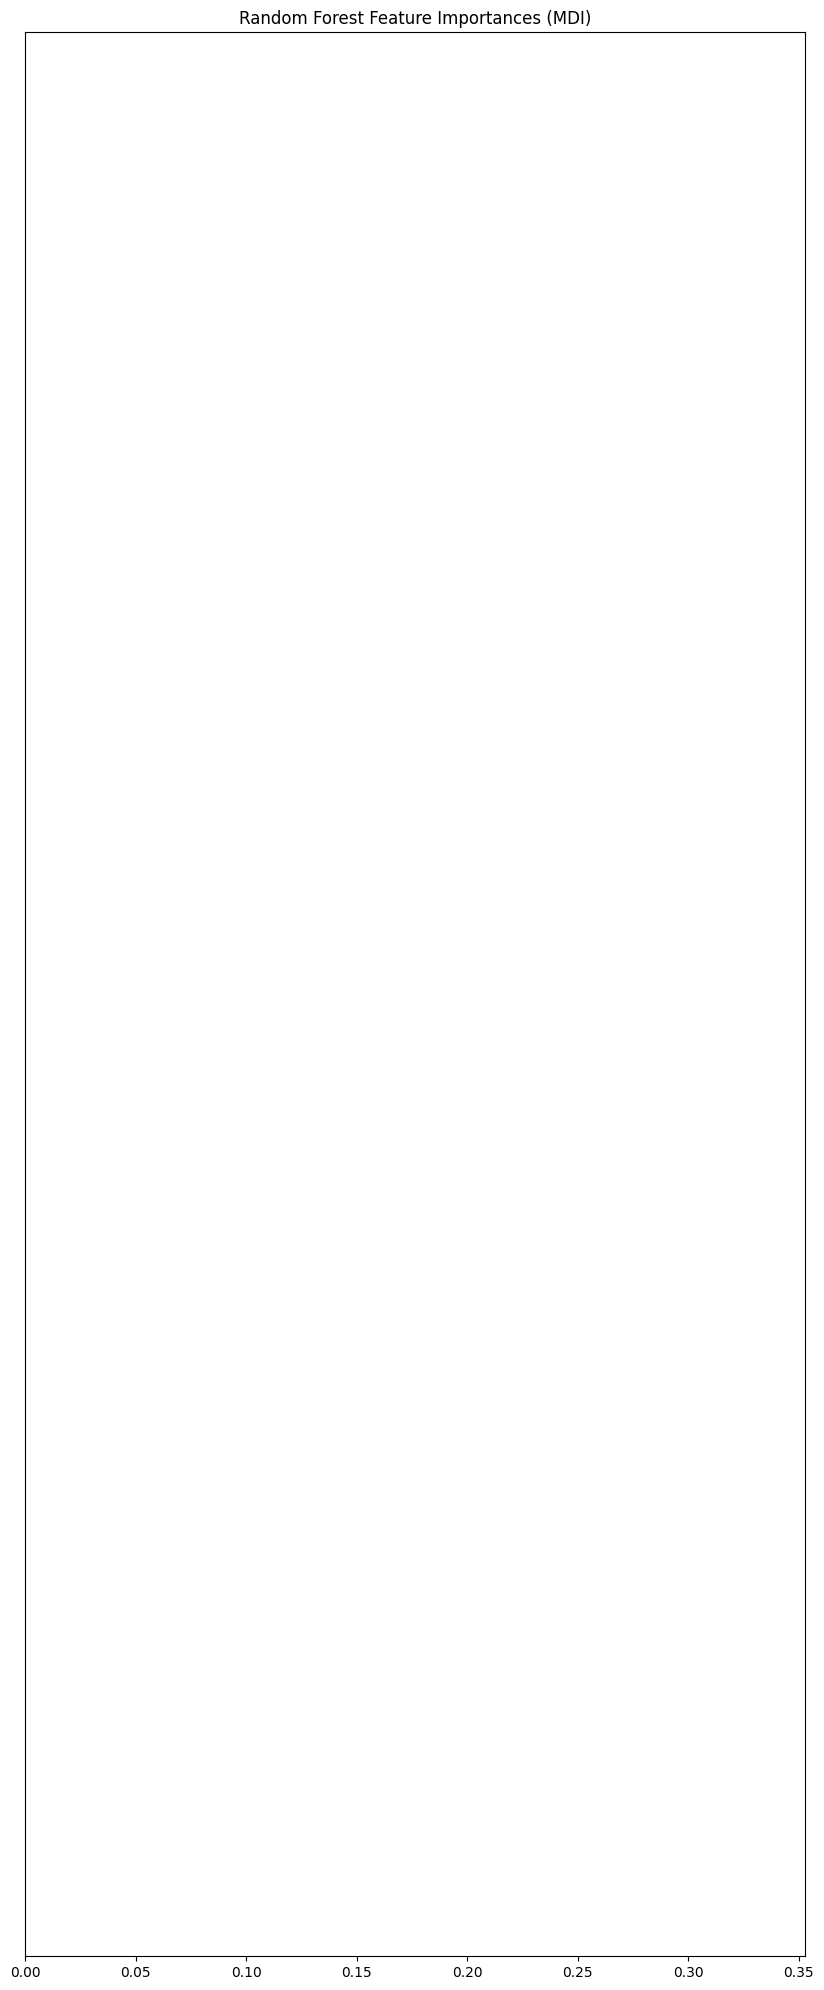

In [109]:
# plot the top ~50 features
import pylab as plt

sorted_idx = np.argsort(tree_feature_importances) #replace ... with your code

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(10,20))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
ax.set_ylim(400, len(feature_names))
plt.show()

#your plot may be different from mine

In [110]:
# CAPTION HERE! How is your model, How is your feature importance results? what can you notice? is it interesting? is it insightful??

My model is fairly good since the model test accuracy is 0.87.

From my analysis, I noticed that there were not that many categorical variables that stuck out as being important to the total site energy.

However, my feature importance results show that features like gross area, the year a building was built, and ghg emissions are important to the total site energy value in KBTU in Boston.

I feel that this is interesting and insightful because the equivalent ghg emissions feature from the other data set analyzed and from the example also show that ghg emissions are important.

*I chose 2 east coast cities (Philadelphia and Boston), but the HW example is about a city on the west coast (Seattle).

# TASK 6 do it for another city! note: the variable names wont be the same


# useful links and methods and functions I used:

```df.dropna()``` to remove observation with missing variables

```df.drop(columns, axis=1)``` to remove features (columns)


```np.log10()``` and ```np.isinf()``` to convert to log space and find infinite values  

`np.hstack([X1, X2])` to concatenate two arrays


one hot encoder https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html and https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/


KNN imputer https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html , https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/, and
https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/  